In [1]:
import os
from joblib import Parallel, delayed
import time
import numpy as np
import pickle
import pylab as pl


In [2]:
time.sleep(80)

In [3]:
total_count = 48


In [4]:


def getTimesThputs(file):
    f = open(file, "r")
    data = f.readlines() 
    times = []
    thputs = []
    latencies = []
    for line in data:
        if not line.startswith('--') and 'current ops/sec; [UPDATE AverageLatency' in line:

#         print(line)
            times.append(line.split('sec:')[0].strip())
            thputs.append(line.split(';')[1].split('current')[0].strip())
            latencies.append(line.split('=')[1].split(']')[0].strip())
            
            print(line,latencies[-1],thputs[-1],times[-1])

    return np.array(times).astype(float), np.array(thputs).astype(float), np.array(latencies).astype(float)/1e6  






def getTimeThps(file, flag):
    
    f = open(file, "r")
    data = f.readlines() 

    times = []
    thputs = []
    for line in data:
        if 'throughput[ops/s]' in line:
            lineData = (line[13+line.find('max[ops/s])>'):-2])
            print(lineData)

            times.append(lineData.split('|')[0])
            thputs.append(lineData.split('|')[-2])
    if (flag): 
        times.append(float(times[-1])+abs(float(times[-1]) - float(times[-2]) ))
        thputs.append(0)
        
    return np.array(times).astype(float), np.array(thputs).astype(float) 

In [5]:
# os.system("aws --region ap-south-1 ec2 describe-instances  --filter Name=instance-type,Values=t2.small --query 'Reservations[*].Instances[*].[PrivateIpAddress]' --output text > all_internal_ips")

# os.system("aws --region ap-south-1 ec2 describe-instances --filter Name=instance-type,Values=t2.small --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text > all_external_ips")



# os.system("aws --region ap-south-1 ec2 describe-instances  --query 'Reservations[*].Instances[*].[PrivateIpAddress]' --output text > all_internal_ips")

# os.system("aws --region ap-south-1 ec2 describe-instances  --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text > all_external_ips")

In [6]:
with open('all_external_ips') as f:
    lines = f.read().splitlines()


lines = [x for x in lines if x!='None']
lines, len(lines)

(['65.0.80.238',
  '65.2.33.122',
  '13.127.177.175',
  '13.232.232.207',
  '13.235.132.64',
  '43.205.213.86',
  '3.110.106.118',
  '3.6.90.238',
  '3.108.194.231',
  '13.233.183.251',
  '15.206.145.201',
  '65.0.129.208',
  '3.108.221.101',
  '13.234.113.12',
  '43.205.231.174',
  '13.232.112.248',
  '13.232.244.136',
  '13.127.53.138',
  '43.205.203.220',
  '13.127.223.50',
  '13.234.59.208',
  '13.126.132.199',
  '13.127.175.161',
  '13.126.211.40',
  '52.66.147.236',
  '15.207.87.239',
  '43.204.25.50',
  '13.233.178.254',
  '13.233.34.168',
  '52.66.200.22',
  '43.205.194.79',
  '13.232.74.205',
  '43.205.231.202',
  '43.204.30.240',
  '3.110.182.243',
  '43.205.198.203',
  '65.2.170.185',
  '13.234.111.83',
  '15.206.79.126',
  '13.126.207.118',
  '13.232.177.182',
  '52.66.119.232',
  '3.110.170.129',
  '13.234.111.242',
  '13.127.189.177',
  '13.127.159.149',
  '65.0.89.212',
  '3.110.225.42',
  '65.2.170.217',
  '52.66.31.15',
  '13.235.244.45',
  '43.205.111.37',
  '43.205.2

In [7]:
for ip in lines:
    if ip!='None':
        current = (ip.split('.'))

        print('ssh -i "FinalKeys.pem" ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com')

ssh -i "FinalKeys.pem" ubuntu@ec2-65-0-80-238.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-65-2-33-122.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-13-127-177-175.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-13-232-232-207.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-13-235-132-64.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-43-205-213-86.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-3-110-106-118.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-3-6-90-238.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-3-108-194-231.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-13-233-183-251.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-15-206-145-201.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-65-0-129-208.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-3-108-221-

In [8]:
## Set number of clusters

nclusters = 0

for folder in os.listdir('.'):
    if 'config' in folder and folder!='config':
        nclusters = nclusters + 1
        
        
print(nclusters)




nreplicas = int(total_count/nclusters)
nodeIps = lines[:nclusters* nreplicas]

nclients = nclusters

# no_cluster_yet_nodes = lines[nclusters* nreplicas:-(nclusters)]
no_cluster_yet_nodes = lines[nclusters* nreplicas:-nclients]



# clientIps = lines[-(nclusters):]
clientIps = lines[-nclients:]



clientIps, no_cluster_yet_nodes

8


(['65.2.170.217',
  '52.66.31.15',
  '13.235.244.45',
  '43.205.111.37',
  '43.205.215.13',
  '52.66.207.248',
  '43.205.95.41',
  '43.205.112.213'],
 [])

In [9]:
## Functions

def setup(i):

    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 3108 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'commands.sh'+' ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:commands.sh'
        
        print(command)
        os.system(command)
        
def initialize(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 3108 | sudo -S ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -t "sudo tc qdisc del dev eth0 root; sudo sh commands.sh; cd BftSmart_Final/simul_latency/; sudo sh node_'+str(i)+'.sh"'
        
        
        os.system(command)
        
        
def git_clone(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -t " sudo git clone https://github.com/tmane002/BftSmart_Final.git"'
        
        
        os.system(command)
        
def git_pull(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -t "git config --global --add safe.directory /home/ubuntu/BftSmart_Final; cd BftSmart_Final; sudo git pull"'
        
        
        os.system(command)
        
def compile_job(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo ./gradlew installDist"'
        
        
        os.system(command)

        
        
def clean_job(i):
    ip = lines[i]
    
    rm_command = 'sudo rm config/currentView; '
    for iter_ in range(nclusters):
        rm_command = rm_command + 'sudo rm config'+str(iter_)+'/currentView; '
        
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "sudo rm nohup.out; cd BftSmart_Final; '+rm_command+'"'
        
        
        os.system(command)
        
        
def clean_all(i):
    ip = lines[i]
    
    rm_command = 'sudo rm -r BftSmart_Final; sudo rm nohup.out;sudo rm nohup_client.out;'

        
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "sudo rm nohup.out; '+rm_command+'"'
        
        
        os.system(command)
        
def run_server_node(i):
    ip = lines[i]
#     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
    if ip!='None' and( ip in nodeIps):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
        os.system(command)
        
        
        
    if ip!='None' and( ip in no_cluster_yet_nodes):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
        os.system(command)        
#         print(command)

def check_node(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -f -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "tail -n 1000 nohup.out"'
        
        
        os.system(command)
#         print(command)


def run_basic_client(i):
    cmd_arg = ''
    
    ip = lines[i]
    if ip!='None' and ip in clientIps:
#     if ip!='None' and ip in nodeIps[1:1+len(clientIps)]:
        
        current = (ip.split('.'))
        
#         cmd_arg = nodeIps[1:1+len(clientIps)].index(ip)
        
        for iter__ in range(len(clientIps)):
            if ip==clientIps[iter__]:
                cmd_arg = iter__
                
                
        
#         print(i, cmd_arg)
            
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup_client.out 2>&1 &"'

        
        os.system(command)


def kill_java(i):
    ip = lines[i]
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo killall java; sudo killall nohup"'
        
        
        os.system(command)
        
        
        
def kill_clients(i):
    ip = lines[i]
    if ip!='None' and ip in clientIps:
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo killall java; sudo killall nohup"'
        
        
        os.system(command)

def run_server_node_check(i):
    ip = lines[i]
#     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
    if ip!='None' and( ip in nodeIps):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
        print(command)
        
        

# for i in range(len(lines)):
#     run_server_node_check(i)

def run_basic_client_check(i):
    cmd_arg = ''
    
    ip = lines[i]
    if ip!='None' and ip in clientIps:
        
        for iter__ in range(len(clientIps)):
            if ip==clientIps[iter__]:
                cmd_arg = iter__
                
                
        
#         print(i, cmd_arg)
            
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup.out 2>&1 &"'

        
        print(command)

In [10]:
# for i in range(len(lines)):
#     run_basic_client_check(i)
    

# def setup(i):

#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'commands.sh'+' ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:commands.sh'
        
        
#         os.system(command)
        
# def initialize(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -t "sudo sh commands.sh"'
        
        
#         os.system(command)
        
        
# def git_clone(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -t " sudo git clone https://tmane002@bitbucket.org/tmane002/BftSmart_Final.git"'
        
        
#         os.system(command)
        
# def git_pull(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -t "git config --global --add safe.directory /home/ubuntu/bftsmartt; cd bftsmartt; sudo git pull"'
        
        
#         os.system(command)
        
# def compile_job(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo ./gradlew installDist"'
        
        
#         os.system(command)

        
        
# def clean_job(i):
#     ip = lines[i]
    
#     rm_command = 'sudo rm config/currentView; '
#     for iter_ in range(nclusters):
#         rm_command = rm_command + 'sudo rm config'+str(iter_)+'/currentView; '
        
    
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "sudo rm nohup.out; cd bftsmartt; '+rm_command+'"'
        
        
#         os.system(command)
        
        
# def clean_all(i):
#     ip = lines[i]
    
#     rm_command = 'sudo rm -r bftsmartt; sudo rm nohup.out;sudo rm nohup_client.out;'

        
    
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "sudo rm nohup.out; '+rm_command+'"'
        
        
#         os.system(command)
        
# def run_server_node(i):
#     ip = lines[i]
# #     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
#     if ip!='None' and( ip in nodeIps):
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
#         os.system(command)
        
        
        
#     if ip!='None' and( ip in no_cluster_yet_nodes):
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
#         os.system(command)        
# #         print(command)

# def check_node(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -f -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "tail -n 1000 nohup.out"'
        
        
#         os.system(command)
# #         print(command)


# def run_basic_client(i):
#     cmd_arg = ''
    
#     ip = lines[i]
#     if ip!='None' and ip in clientIps:
# #     if ip!='None' and ip in nodeIps[1:1+len(clientIps)]:
        
#         current = (ip.split('.'))
        
# #         cmd_arg = nodeIps[1:1+len(clientIps)].index(ip)
        
#         for iter__ in range(len(clientIps)):
#             if ip==clientIps[iter__]:
#                 cmd_arg = iter__
                
                
        
# #         print(i, cmd_arg)
            
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd bftsmartt; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup_client.out 2>&1 &"'

        
#         os.system(command)


# def kill_java(i):
#     ip = lines[i]
    
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo killall java; sudo killall nohup"'
        
        
#         os.system(command)
        
        
        
# def kill_clients(i):
#     ip = lines[i]
#     if ip!='None' and ip in clientIps:
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo killall java; sudo killall nohup"'
        
        
#         os.system(command)

# def run_server_node_check(i):
#     ip = lines[i]
# #     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
#     if ip!='None' and( ip in nodeIps):
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
#         print(command)
        
        

# # for i in range(len(lines)):
# #     run_server_node_check(i)

# def run_basic_client_check(i):
#     cmd_arg = ''
    
#     ip = lines[i]
#     if ip!='None' and ip in clientIps:
        
#         for iter__ in range(len(clientIps)):
#             if ip==clientIps[iter__]:
#                 cmd_arg = iter__
                
                
        
# #         print(i, cmd_arg)
            
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd bftsmartt; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup.out 2>&1 &"'

        
#         print(command)

# # for i in range(len(lines)):
# #     run_basic_client_check(i)
    

In [11]:
## First Time Setup

lines, len(lines)

(['65.0.80.238',
  '65.2.33.122',
  '13.127.177.175',
  '13.232.232.207',
  '13.235.132.64',
  '43.205.213.86',
  '3.110.106.118',
  '3.6.90.238',
  '3.108.194.231',
  '13.233.183.251',
  '15.206.145.201',
  '65.0.129.208',
  '3.108.221.101',
  '13.234.113.12',
  '43.205.231.174',
  '13.232.112.248',
  '13.232.244.136',
  '13.127.53.138',
  '43.205.203.220',
  '13.127.223.50',
  '13.234.59.208',
  '13.126.132.199',
  '13.127.175.161',
  '13.126.211.40',
  '52.66.147.236',
  '15.207.87.239',
  '43.204.25.50',
  '13.233.178.254',
  '13.233.34.168',
  '52.66.200.22',
  '43.205.194.79',
  '13.232.74.205',
  '43.205.231.202',
  '43.204.30.240',
  '3.110.182.243',
  '43.205.198.203',
  '65.2.170.185',
  '13.234.111.83',
  '15.206.79.126',
  '13.126.207.118',
  '13.232.177.182',
  '52.66.119.232',
  '3.110.170.129',
  '13.234.111.242',
  '13.127.189.177',
  '13.127.159.149',
  '65.0.89.212',
  '3.110.225.42',
  '65.2.170.217',
  '52.66.31.15',
  '13.235.244.45',
  '43.205.111.37',
  '43.205.2

In [12]:
# for i in range(10):
#     setup(i)


results = Parallel(n_jobs=len(lines))(delayed(setup)(i) for i in range(len(lines)))
print(results)  

[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [13]:
results = Parallel(n_jobs=len(lines))(delayed(initialize)(i) for i in range(len(lines)))
print(results)  

[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Error: Cannot delete qdisc with handle of zero.
fatal: destination path 'BftSmart_Final' already exists and is not an 

Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://ap-so

fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.


Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Reading package lists...Reading package lists...Reading package lists...Reading package lists...Reading package lists...Reading package lists...Reading package lists...Reading package lists...Reading package lists...
Reading package lists...
Building dependency tree...
Reading package lists...
Building dependency tree...
Reading package lists...
Reading package lists...
Building dependency tree...
Reading packag

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found



Reading state information...

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+

Reading state information...

Reading state information...
ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
 

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
[sudo] password for tejas: [sudo] password for tejas: 'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
[sudo] password for tejas: job.sh: 11: sdk: not found
[sudo] password for tejas: [sudo] password for tejas: 'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
[sudo] password for tejas: 
[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: 


iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.

Reading state information...

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-     

[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: 'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
[sudo] password for tejas: [sudo] password for tejas: 'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] pass

iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.


'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
[sudo] password for tejas: 
[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be al

Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease


Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Error: Cannot delete qdisc with handle of zero.
Pseudo-terminal will not be allocated because stdin is not a terminal.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Error: Cannot delete qdisc with handle of zero.
Error: Cannot delete qdisc with handle of zero.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
Error: Cannot delete qdisc 

Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:1 http://ap-south-1

Error: Cannot delete qdisc with handle of zero.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
Error: Cannot delete qdisc with handle of zero.
Error: Cannot delete qdisc with handle of zero.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
Error: Cannot delete qdisc with handle of zero.
Error: Cannot delete qdisc with handle of zero.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
Error: Cannot delete qdisc with handle of zero.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
Error: Cannot delete qdisc with handle of zero.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
Error: Cannot delete qdisc with handle of zero.
Error: 

Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:1 http://ap-south-1

fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
Error: Cannot delete qdisc with handle of zero.
Error: Cannot delete qdisc with handle of zero.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
Error: Cannot delete qdisc with handle of zero.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
Error: Cannot delete qdisc with handle of zero.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
Error: Cannot delete qdisc with handle of zero.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
Error: Cannot delete qdisc with handle of zero.
Error: Cannot de

Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu ja

fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
Error: Cannot delete qdisc with handle of zero.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.
Error: Cannot delete qdisc with handle of zero.
fatal: destination path 'BftSmart_Final' already exists and is not an empty directory.


Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Reading package lists...Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
H


build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.

Reading state information...
Reading state information...

Reading state information...
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
curl is already the newest version (7.81.0-1ubuntu1.13).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.

Reading package lists...build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
Building dependency tree...Building dependency tree...build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.

Re

curl is already the newest version (7.81.0-1ubuntu1.13).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
curl is already the newest version (7.81.0-1ubuntu1.13).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
curl is already the newest version (7.81.0-1ubuntu1.13).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
curl is already the newest version (7.81.0-1ubuntu1.13).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
curl is already the newest version (7.81.0-1ubuntu1.13).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
curl is already the newest version (7.81.0-1ubuntu1.13).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
curl is already the newest version (7.81.0-1ubuntu1.13).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.

Reading state information...
curl is already the newest version (7.81.0-1ubuntu1.13).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
cu

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found


 dMMMMmo-.``````..-:/osyhddddho.           `+shdh+.   hMMM:     :MmMMMM/   ./yy/` `:sys+/+sh/
 .dMMMMMMmdddddmmNMMMNNNNNMMMMMs           sNdo-      dMMM-  `-/yd/MMMMm-:sy+.   :hs-      /N`
  `/ymNNNNNNNmmdys+/::----/dMMm:          +m-         mMMM+ohmo/.` sMMMMdo-    .om:       `sh
     `.-----+/.`       `.-+hh/`         `od.          NMMNmds/     `mmy:`     +mMy      `:yy.
           /moyso+//+ossso:.           .yy`          `dy+:`         ..       :MMMN+---/oys:
         /+m:  `.-:::-`               /d+                                    +MMMMMMMNh:`
        +MN/                        -yh.                                     `+hddhy+.
       /MM+                       .sh:
      :NMo                      -sh/
     -NMs                    `/yy:
    .NMy                  `:sh+.
   `mMm`               ./yds-
  `dMMMmyo:-.````.-:oymNy:`
  +NMMMMMMMMMMMMMMMMms:`
    -+shmNMMMNmdy+:`


                                                                 Now attempting installation...


Lookin

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found



                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`       `-/osyh/ossssssdNMM`           .sh:         yMMN`      /m.
         -dh-           :ymNMMMMy  `-/shmNm-`:N/-.``   `.sN            /N-         `NMMy      .m/
  

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found


Building dependency tree...Building dependency tree...
                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`       `-/osyh/ossssssdNMM`           .sh:         yMMN`      /m.
         -dh-           :ymNMMMMy  `-/shmNm-`:

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
job.sh: 11: sdk: not found


    .NMy                  `:sh+.
   `mMm`               ./yds-
  `dMMMmyo:-.````.-:oymNy:`
  +NMMMMMMMMMMMMMMMMms:`
    -+shmNMMMNmdy+:`


                                                                 Now attempting installation...


Looking for a previous installation of SDKMAN...
Looking for unzip...
Not found.
 Please install unzip on your system using your favourite package manager.

 Restart after installing unzip.

'exit 1': command failed with exit code 1.
Building dependency tree...
 Restart after installing unzip.

'exit 1': command failed with exit code 1.
Reading package lists...Building dependency tree...Reading package lists...Building dependency tree...Building dependency tree...Reading package lists...
                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`      

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
job.sh: 11: sdk: not found


Reading package lists...ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.

Building dependency tree...
Reading state information...

Reading state information...

iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
Building dependency tree...
Reading state information...

Reading state information...
Reading package lists...
Reading state information...
Reading state information...ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.


ant is already the newest 

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found



Reading state information...
Building dependency tree...ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
Reading package lists...Reading package lists...
Reading state information...
Reading package lists...

Reading package lists...ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.

Reading state information...Reading package lists...Building dependency tree...
Building dependency tree...
ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
Reading package lists...
Building dependency tree...ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remo

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
job.sh: 11: sdk: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: 'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./grad


Reading state information...
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.


Reading state information...
Reading state information...
 Please install unzip on your system using your favourite package manager.

 Restart after installing unzip.

'exit 1': command failed with exit code 1.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.

Reading state information...

Reading state information...

Reading state information...
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.

Reading state information...Reading package lists...

Building dependency tree...iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 t

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: 'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found./gradlew: not found

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I

iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.

Reading state information...
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 94 

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found

job.sh: 11: sdk: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
job.sh: 11: sdk: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


In [14]:
## GIT Clone/Pull



results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))


print(results)  

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': N

Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Clonin

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [15]:
## Compile Job

results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
print(results)  

Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated A


> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :jar
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated 

> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar
> Task :

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated 


> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated 


> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe oper


> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.

Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operat

> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava
> Task :jar
> Task :jar
> Task :jar
> Task :jar

> Task :compileJava

> Task :compileJava




Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated


> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava> Task :jar


> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes




Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe ope


> Task :compileJava

> Task :processResources NO-SOURCE

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :classes

> Task :compileJava
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :installDist
> Task :jar
> Task :jar


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava
> Task :jar

> Task :compileJav

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :compileJava
> Task :jar
> Task :jar

> Task :compileJava

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processR

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar
> Task :jar
> Task :installDist
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :compileJava

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist



Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar

> Task :compileJava
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 23s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 23s
3 actionable tasks: 3 executed
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [16]:
## CLEAN SERVERS

results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

print(results)  

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directoryrm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory

rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config1/currentView'

rm: cannot remove 'config7/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'config6/currentView': No such file or directory
rm: cannot remove 'config7/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: can

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


rm: rm: cannot remove 'config4/currentView'rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: : No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory
rm: rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: rm: cannot remove 'config6/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: rm: cannot remove 'config6/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm:

In [17]:
## Setup Client and nodeIPS
len(nodeIps), len(clientIps)

(48, 8)

In [18]:
# ## RUN SERVERS

# results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# print(results)  

# ### CHECK NODE RESULT

# check_node(7)

# ## Run basic client

# # time.sleep(20)
# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# print(results)  

# check_node(0)

# time.sleep(60)

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))

In [19]:
## Main Job

# os.system('git add .; git commit -m "test";git push')

experiment = 'GeoRun_tot_'+str(total_count)+'_clusters_'+str(nclusters)

In [20]:
results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# print(results) 




results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))


results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# print(results)  


print('XXXXXXXX Started Servers XXXXXXXXXXXX')

time.sleep(40)

check_node(7)



print('XXXXXXXX Started Clients XXXXXXXXXXXX')

results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
time.sleep(50)

results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
bash: line 1: cd: BftSmart_Final: No such file or directory
nohup: no process found
bash: line 1: cd: BftSmart_Final: No such file or directory
bash: line 1: cd: BftSmart_Final: No such file or directory
bash: line 1: cd: BftSmart_Final: No such file or directory
bash: line 1: cd: BftSmart_Final: No such file or directory
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
bash: line 1: cd: BftSmart_Final

Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmar

Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)

> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.




> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated 


> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent bui

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated A



> Task :compileJava

> Task :compileJava
> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes


> Task :compileJava
> Task :compileJava


> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava




Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecate


> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava> Task :jar


> Task :compileJava
> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava


> Task :compileJava
> Task :compileJava

> Task :compileJava
> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava
> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava


> Task :compileJava> Task :jar

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes



> Task :compileJava
> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated 


> Task :compileJava



> Task :compileJava
> Task :jar

> Task :processResources NO-SOURCE

> Task :compileJava

> Task :compileJava
> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar


> Task :compileJava
> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :classes


> Task :compileJava> Task :jar

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/


> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava
> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava> Task :jar

> Task :compileJava


> Task :processResources NO-SOURCE
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes


> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :cl

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated 



> Task :installDist


> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar

> Task :compileJava> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed


> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :jar
BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResou

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar

> Task :compileJava> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :compileJava

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESS

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist


> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed


rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config3/currentView'rm: cannot remove 'config4/currentView': No such file or directoryrm: cannot remove 'nohup.out': No such file or directory


rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'config5/currentView'rm: cannot remove 'config4/currentView': No such file or directory
: No such file or directory
rm: cannot remove 'config6/currentView': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'config7/currentView': No such file or directory
rm: cannot remove 'config6/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config7/currentView': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'config6/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config7/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: ca

rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'config6/currentView': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'con

XXXXXXXX Started Servers XXXXXXXXXXXX
XXXXXXXX Started Clients XXXXXXXXXXXX
config+cinfo.getClusterNumber(id) is: config1
-- Creating current view from configuration file
-- myPort, InetAddress.getByName(myAddress) and myAddress are: 11071, /172.31.34.187, 172.31.34.187
-- getConnection HERE 
-- Getting connection for ret: null, remoteId: 0
-- Getting connection for remoteId: 0
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:0  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- After Adding connection, ret: bftsmart.communication.server.ServerConnection@7748410a
-- getConnection HERE 
-- Getting connection for ret: null, remoteId: 1
-- Getting connection for remoteId: 1
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:1  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- After Adding connection, ret: bftsmart.communication.server.ServerConnection@60015ef5
-- getConnection HERE 
-- Getting connection for ret: null,

nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no proces

In [21]:
if not os.path.exists('../Experiments/'+experiment):
    os.mkdir('../Experiments/'+experiment)

os.system('cd ../Experiments/'+experiment+';rm *;cd ../; rm '+experiment+'.png')

for ip in nodeIps[:1]:
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

        os.system(command)
        
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
#         print(command)
        os.system(command)

        
for ip in no_cluster_yet_nodes:
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

        os.system(command)
        

for ip in clientIps:    
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out'
        print(command)
        os.system(command)

rm: cannot remove 'GeoRun_tot_48_clusters_8.png': No such file or directory
scp: /home/ubuntu/nohup_client.out: No such file or directory


scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-65-2-170-217.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/GeoRun_tot_48_clusters_8/nohup_client_48.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-52-66-31-15.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/GeoRun_tot_48_clusters_8/nohup_client_49.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-13-235-244-45.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/GeoRun_tot_48_clusters_8/nohup_client_50.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-43-205-111-37.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/GeoRun_tot_48_clusters_8/nohup_client_51.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-43-205-215-13.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_clie

 7 sec: 1 operations; 1 current ops/sec; [UPDATE AverageLatency(us)=876278] 
 876278 1 7
 8 sec: 59 operations; 57.88 current ops/sec; [UPDATE AverageLatency(us)=1908065.36] 
 1908065.36 57.88 8
 9 sec: 100 operations; 41 current ops/sec; [UPDATE AverageLatency(us)=1991290.1] 
 1991290.1 41 9
 10 sec: 101 operations; 1 current ops/sec; [UPDATE AverageLatency(us)=2582885] 
 2582885 1 10
 11 sec: 200 operations; 99 current ops/sec; [UPDATE AverageLatency(us)=2459040.23] 
 2459040.23 99 11
 12 sec: 300 operations; 99.9 current ops/sec; [UPDATE AverageLatency(us)=1371602.84] 
 1371602.84 99.9 12
 13 sec: 341 operations; 40.71 current ops/sec; [UPDATE AverageLatency(us)=1125609.78] 
 1125609.78 40.71 13
 14 sec: 403 operations; 61.94 current ops/sec; [UPDATE AverageLatency(us)=1186039.21] 
 1186039.21 61.94 14
 15 sec: 502 operations; 99 current ops/sec; [UPDATE AverageLatency(us)=1325023.24] 
 1325023.24 99 15
 16 sec: 601 operations; 98.9 current ops/sec; [UPDATE AverageLatency(us)=162799

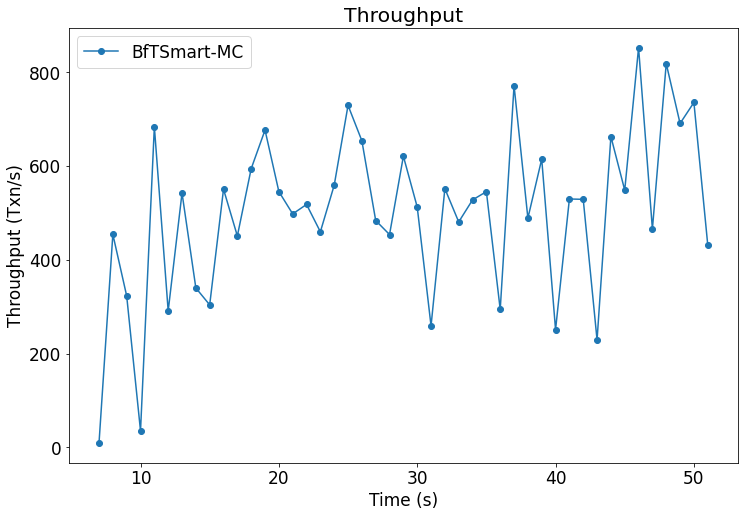

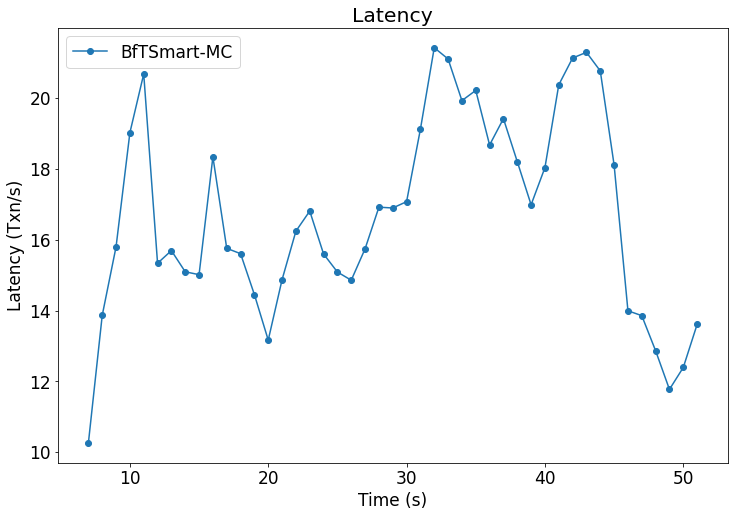

In [22]:
times_thputsDict = {}
times_latsDict = {}

for ip in clientIps[:1]:    
    i = lines.index(ip)
    
    times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
    for i in range(len(times)):
        times_thputsDict[times[i]] = thputs[i]
        times_latsDict[times[i]] = lats[i]
        

for ip in clientIps[1:]:    
    i = lines.index(ip)
    
    times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
    for i in range(len(times)):
        
        if times[i] in times_thputsDict.keys():
            times_thputsDict[times[i]] += thputs[i]
            
        if times[i] in times_latsDict.keys():
            times_latsDict[times[i]] += lats[i]
    

PIK = '../Experiments/'+experiment+"/pickle.dat"

data = [times_thputsDict, times_latsDict]

with open(PIK, "wb") as f:
    pickle.dump(data, f)


data2 = []
with open(PIK, "rb") as f:
    data2 =  pickle.load(f)


dict1 = data2[0]
dict2 = data2[1]



times1 = np.array(list(dict1.keys()))
thputs = np.array(list(dict1.values()))

times2 = np.array(list(dict2.keys()))
lats = np.array(list(dict2.values()))

times1

import pylab as pl

pl.figure(figsize = (12,8))
pl.rcParams.update({'font.size': 17})
pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')


pl.title(r'Throughput')


pl.xlabel('Time (s)')
pl.ylabel('Throughput (Txn/s)')
pl.legend()
pl.savefig('../Experiments/'+experiment+'/out1.png', dpi = 150)
pl.show()




pl.figure(figsize = (12,8))
pl.rcParams.update({'font.size': 17})
pl.plot(times1[:], lats[:], '-o', label='BfTSmart-MC')


pl.title(r'Latency')


pl.xlabel('Time (s)')
pl.ylabel('Latency (Txn/s)')
pl.legend()
pl.savefig('../Experiments/'+experiment+'/out2.png', dpi = 150)
pl.show()

In [23]:
lats, np.average(lats[-85:-5])

(array([10.259342  , 13.86416634, 15.800086  , 19.02358424, 20.68281007,
        15.33617783, 15.69392366, 15.09518485, 15.01425514, 18.34086446,
        15.75780275, 15.60707744, 14.45081924, 13.16626327, 14.87282304,
        16.242844  , 16.81000804, 15.59827047, 15.08862236, 14.85734163,
        15.74453029, 16.92026915, 16.896974  , 17.07559551, 19.12315602,
        21.42404504, 21.10488007, 19.92921704, 20.21780578, 18.67663319,
        19.41955656, 18.20745152, 16.9889085 , 18.03650669, 20.37512402,
        21.13203833, 21.29330358, 20.76821811, 18.112082  , 13.99449308,
        13.85704062, 12.86572136, 11.77441168, 12.39327019, 13.6082662 ]),
 17.17507638275)